# Funzioni

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.stats import beta as beta_dens
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import seaborn as sns

def idx2path(index, len_output_path = 10):
    binario = [int(bit) for bit in bin(index)[2:]]
    codifica_binaria = [0] * (len_output_path - len(binario)) + binario[-len_output_path:]
    return codifica_binaria

def path2idx(path):
    return int(''.join(map(str, path)), 2)

def inv_G0(p):
    return p

def count_data_in_B(data, B):
    sum = 0
    if np.isscalar(data):
      if data >= B[0] and data <= B[1]:
        sum = sum + 1
    else:
      for i in range(len(data)):
        if data[i] >= B[0] and data[i] <= B[1]:
          sum = sum + 1
    return sum

def sample_beta(a,b, size = 1):
    if size == 1:
      return np.random.beta(a, b, size=size)[0]
    else:
      return np.random.beta(a, b, size=size)

In [2]:
def polya_tree_posterior(data, c = 5, depth = 10):
    all_B = [[0,1]]
    all_alpha = [np.zeros(1)]
    for m in range(1, depth + 1):
      k = int(2 ** m)
      all_B_m = np.zeros((k, 2))
      all_alpha_m = np.zeros(k)
      for i in range(k):
        if i == 0:
          all_B_m[i,0] = 0
        else:
          all_B_m[i,0] = inv_G0(i/k)

        if i == k-1:
          all_B_m[i,1] = 1
        else:
          all_B_m[i,1] = inv_G0((i+1)/k)

        all_alpha_m[i] = c * (m**2) + count_data_in_B(data, all_B_m[i,:])

      all_B.append(all_B_m)
      all_alpha.append(all_alpha_m)

    return all_alpha, all_B

In [3]:
def sample_from_polya_tree(all_alpha):
    all_p = [1]
    depth = len(all_B) - 1
    for m in range(1,depth+1):
      k = int(2 ** m)
      all_p_m = np.zeros(k)
      all_alpha_m = all_alpha[m]
      i = 0
      while i < k:
        p = sample_beta(all_alpha_m[i], all_alpha_m[i+1])
        all_p_m[i] = p
        all_p_m[i + 1] = 1 - p
        i = i + 2
      all_p.append(all_p_m)
    N = 2 ** depth
    return_probs = np.zeros(N)
    for i in range(N):
      final_p = 1
      path = idx2path(i, len_output_path = depth)
      for m in range(1,depth + 1):
        all_p_m = all_p[m]
        final_p = final_p * all_p_m[path2idx(path[:m])]
      return_probs[i] = final_p
    return all_p, return_probs

In [4]:
def compute_predictive(all_alpha, all_B):
  depth = len(all_B) - 1
  k = 2 ** depth
  predictive_prob = np.zeros(k)
  for i in range(k):
    prob = 1
    path = idx2path(i, len_output_path=depth)
    for m in range(1, depth+1):
      index = path2idx(path[:m])
      if index % 2 == 0:
        prob = prob * all_alpha[m][index]/(all_alpha[m][index] + all_alpha[m][index+1])
      else:
        prob = prob * all_alpha[m][index]/(all_alpha[m][index] + all_alpha[m][index-1])

    predictive_prob[i] = prob
  return predictive_prob

In [5]:
def sample_from_categorical_distribution(intervals, probabilities, n):
  sampled_points = np.zeros(n)
  for i in range(n):
    selected_interval_index = np.random.choice(len(intervals), p=probabilities)
    selected_interval = intervals[selected_interval_index]
    sample = np.random.uniform(selected_interval[0], selected_interval[1])
    sampled_points[i] = sample
  return sampled_points

In [6]:
def update_alphas(old_alphas, all_B, new_data):
    new_alphas = old_alphas
    depth = len(all_B) - 1
    for m in range(1, depth + 1):
      k = int(2 ** m)
      for i in range(k):
        new_alphas[m][i] += count_data_in_B(new_data, all_B[m][i,:])

    return new_alphas

# Plot di 30 densità ~ $ PT(G_0, (A | \vec y)) ,  G_0 = U_{[0,1]} $ , e della predittiva $ P(y_{n+1} | \vec y) $




In [7]:
sample_size = 10000

# sample = sample_beta(2,2,size = sample_size)                 # y ~ beta(2,2)
# sample = sample_beta(10,1,size = sample_size)                # y ~ beta(10,1)
sample = np.random.uniform(0, 1/4, sample_size)              # y ~ Unif(0, 0.25)

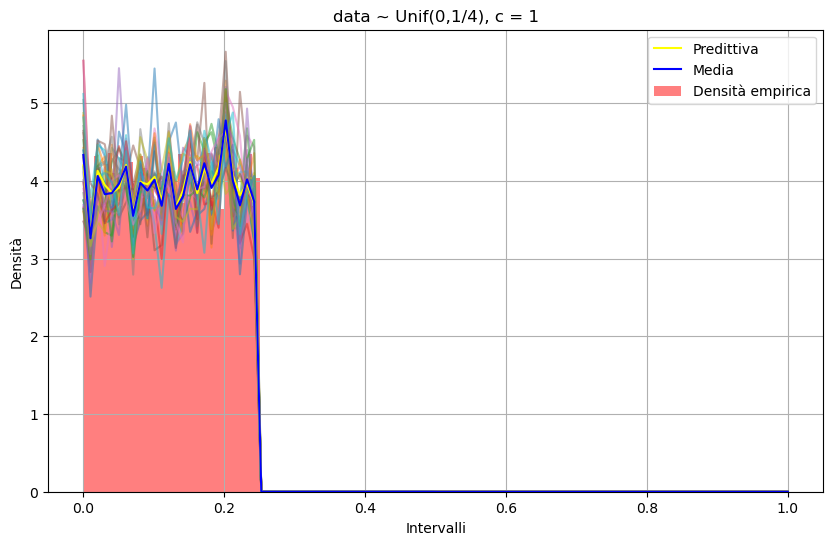

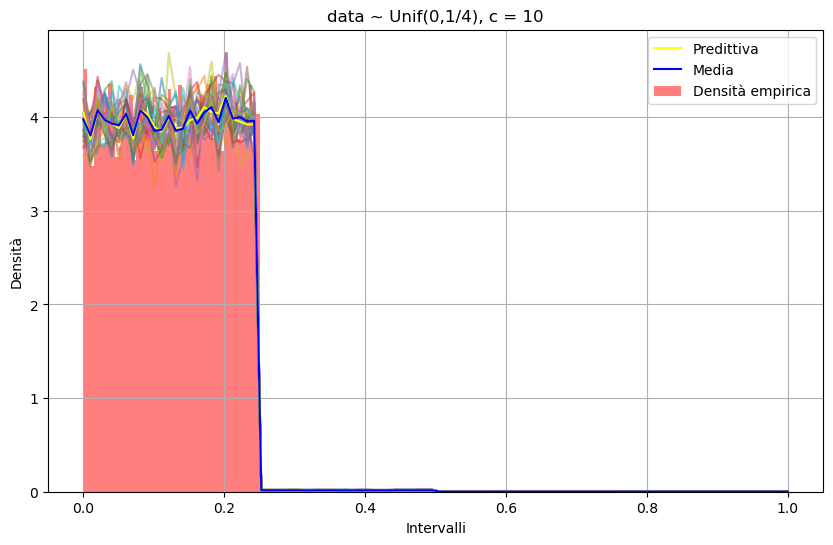

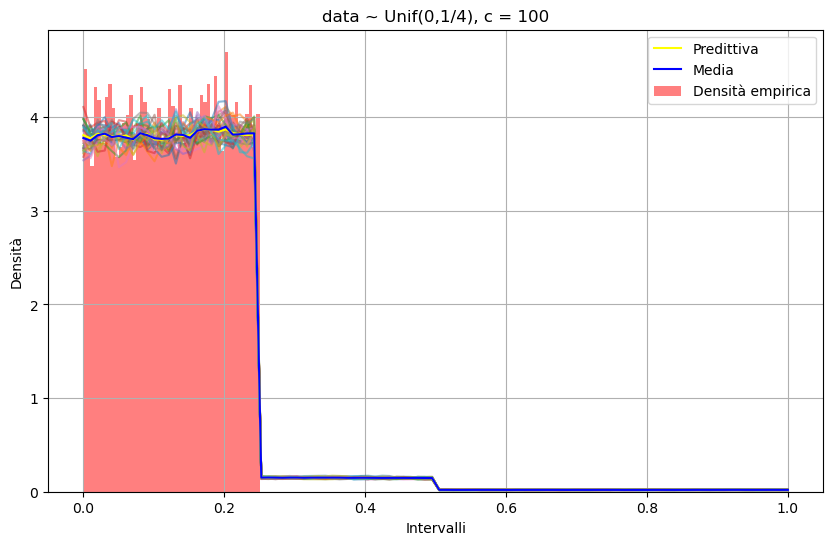

[[0.00000000e+00 9.76562500e-04]
 [9.76562500e-04 1.95312500e-03]
 [1.95312500e-03 2.92968750e-03]
 ...
 [9.97070312e-01 9.98046875e-01]
 [9.98046875e-01 9.99023438e-01]
 [9.99023438e-01 1.00000000e+00]]


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

c_values = [1, 10, 100]                                                                       # Valori di c

num_samples = 30                                                                              # Numero di distribuzioni campionate per ogni valore di c
depth = 10

for c in c_values:
    all_alpha, all_B = polya_tree_posterior(data=sample, c=c, depth=depth)
    final_intervals = all_B[-1]
    sampled_distributions = []
    mean = 0

    # Campiona distribuzioni dal Polya Tree
    for _ in range(num_samples):
        _, sampled_distribution = sample_from_polya_tree(all_alpha)
        sampled_distributions.append(sampled_distribution)
        mean += sampled_distribution

    mean /= num_samples
    x_points = (final_intervals[:, 0] + final_intervals[:, 1]) / 2
    widths = np.diff(final_intervals, axis=1).flatten()

    plt.figure(figsize=(10, 6))

    for sampled_distribution in sampled_distributions:
        area = np.sum(sampled_distribution * widths)
        normalized_distribution = sampled_distribution / area
        f = interp1d(x_points, normalized_distribution, kind='linear', fill_value="extrapolate")
        x_interp = np.linspace(final_intervals[0, 0], final_intervals[-1, 1], 100)
        y_interp = f(x_interp)
        plt.plot(x_interp, y_interp, alpha=0.5)

    sampled_distribution = compute_predictive(all_alpha, all_B)                                                        # Plot della predittiva
    area = np.sum(sampled_distribution * widths)
    normalized_distribution = sampled_distribution / area
    f = interp1d(x_points, normalized_distribution, kind='linear', fill_value="extrapolate")
    x_interp = np.linspace(final_intervals[0, 0], final_intervals[-1, 1], 100)
    y_interp = f(x_interp)
    plt.plot(x_interp, y_interp, alpha=1, color="yellow", label="Predittiva")

                                                                                                                        # Plot della media
    sampled_distribution = mean
    area = np.sum(sampled_distribution * widths)
    normalized_distribution = sampled_distribution / area
    f = interp1d(x_points, normalized_distribution, kind='linear', fill_value="extrapolate")
    x_interp = np.linspace(final_intervals[0, 0], final_intervals[-1, 1], 100)
    y_interp = f(x_interp)
    plt.plot(x_interp, y_interp, alpha=1, color="blue", label="Media")

    plt.hist(sample, color='red', label='Densità empirica', bins=50, density=True, alpha=0.5)

    plt.xlabel("Intervalli")
    plt.ylabel("Densità")
    plt.legend()
    plt.title(f"data ~ Unif(0,1/4), c = {c}")                                                                            # Titolo del plot
    plt.grid()
    plt.show()

# Sampling di $ m $ punti da un sample $ g$ ~ $ PT(G_0, (A | \vec y)) $  (metodo tutti insieme)

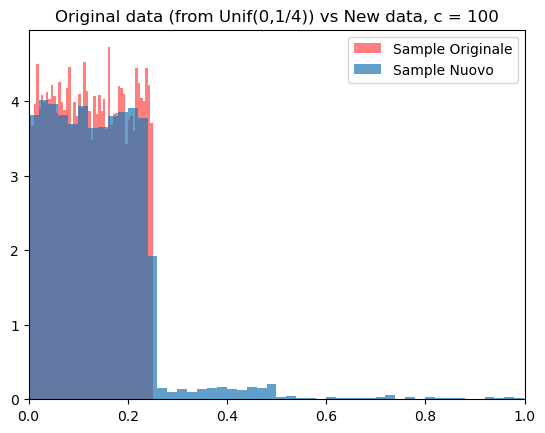

1024
1024
[3.83058879e-03 3.72959998e-03 3.69488231e-03 ... 1.88408560e-05
 1.92817495e-05 1.94476998e-05]


In [14]:
m = 10000 # numero di punti samplati
c = 100

# sample = sample_beta(2,2,size = sample_size)                 # y ~ beta(2,2)
# sample = sample_beta(10,1,size = sample_size)                # y ~ beta(10,1)
sample = np.random.uniform(0, 1/4, sample_size)              # y ~ Unif(0, 0.25)

all_alpha, all_B = polya_tree_posterior(data=sample, c=c, depth=depth)
_, g = sample_from_polya_tree(all_alpha)
sample_new = sample_from_categorical_distribution(intervals = final_intervals, probabilities = g, n = m)  # se campi probabilities = g con "compute_predictive(all_alpha, all_B)" fa sampling dalla predictve, ma a Mario non piace
plt.hist(sample, color='red', label='Sample Originale', bins = 50, density = True, alpha = 0.5)
plt.hist(sample_new, label = "Sample Nuovo", bins = 50, density = True, alpha = 0.7)
plt.title(f"Original data (from Unif(0,1/4)) vs New data, c = {c}")
plt.legend()
plt.xlim(0,1)
plt.show()

print(len(g))
print(len(final_intervals))

# Sampling di $ m $ punti t.c.
$ y_i $ ~ $ PT(G_0, (A | y_1 ... y_{n + i - 1} )) ~~~~\forall ~ i = n + 1 , ... , n + 1 + m$  (metodo condizionato)

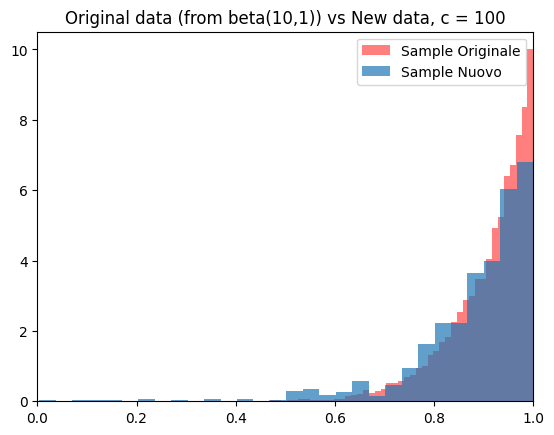

In [ ]:
m = 1000
c = 100

# sample = sample_beta(2,2,size = sample_size)                 # y ~ beta(2,2)
sample = sample_beta(10,1,size = sample_size)                # y ~ beta(10,1)
# sample = np.random.uniform(0, 1/4, sample_size)              # y ~ Unif(0, 0.25)

all_alpha, all_B = polya_tree_posterior(data = sample, c = c, depth = 10)
final_intervals = all_B[-1]
new_alphas = all_alpha

new_data = []
for i in range(m):

  if len(new_data) != 0:
    new_alphas = update_alphas(old_alphas = new_alphas, all_B = all_B, new_data = new_data[-1])

  _, g = sample_from_polya_tree(new_alphas)
  new_data.append(sample_from_categorical_distribution(intervals = final_intervals, probabilities = g, n = 1)[0])

plt.hist(sample, color='red', label='Sample Originale', density = True, bins = 50, alpha = 0.5)
plt.hist(new_data, label = "Sample Nuovo", bins = 30, density = True, alpha = 0.7)
plt.title(f"Original data (from beta(10,1)) vs New data, c = {c}")
plt.legend()
plt.xlim(0,1)
plt.show()


# Robe quantitative

In [10]:
sample_size = 10000
depth = 10
k = 2 ** depth
f = np.zeros(k)
_, all_B = polya_tree_posterior(data=[], c=1, depth=depth)   # il valore di c è inutile, il PT mi serve solo per calcolare gli intervalli
final_intervals = all_B[-1]




sample = sample_beta(2,2,size = sample_size)                 # y ~ beta(2,2)                 # Runnare i due blocchi insieme per ogni distribuzione, sia il sample che il ciclo for dove viene definita f
for i in range(k):                                                                           # f è la densità reale dei dati, salvata in un vettore di lunghezza 1024
  x = (final_intervals[i][0] + final_intervals[i][0])/2
  f[i] = beta_dens.pdf(x, 2, 2)
f /= sum(f)



# sample = sample_beta(10,1,size = sample_size)                # y ~ beta(10,1)
# for i in range(k):
#   x = (final_intervals[i][0] + final_intervals[i][0])/2
#   f[i] = beta_dens.pdf(x, 10, 1)
# f /= sum(f)



# sample = np.random.uniform(0, 1/4, sample_size)              # y ~ Unif(0, 0.25)
# f = np.ones(int(k/4)) * 4
# f /= sum(f)



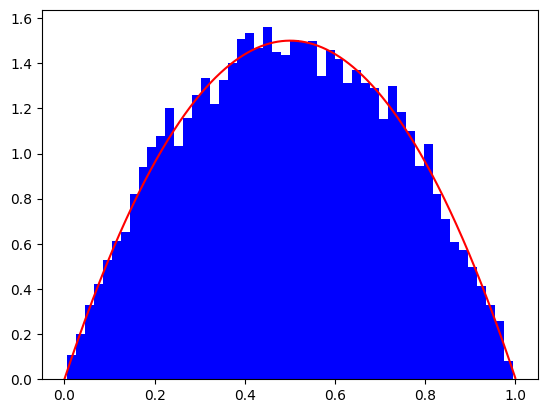

In [29]:
plt.plot(np.linspace(0,1,1024),f * 1024, color = "red")
plt.hist(sample, density = True, color = "blue", bins = 50)
plt.show()

In [30]:
c_values = [0.5, 1, 5, 10, 50, 100, 500]

num_samples = 100

L1_distances = []
Hellinger_distances = []
for c in c_values:
    all_alpha, all_B = polya_tree_posterior(data=sample, c=c, depth=depth)
    final_intervals = all_B[-1]
    L1_distance = []
    Hellinger_distance = []

    for _ in range(num_samples):
        _, g = sample_from_polya_tree(all_alpha)
        L1_distance.append(np.sum(np.abs(g - f))/k)                                   # L1 distance
        Hellinger_distance.append(np.sum(((np.sqrt(g) - np.sqrt(f))**2))/k)           # H distance

    L1_distances.append(L1_distance)
    Hellinger_distances.append(Hellinger_distance)


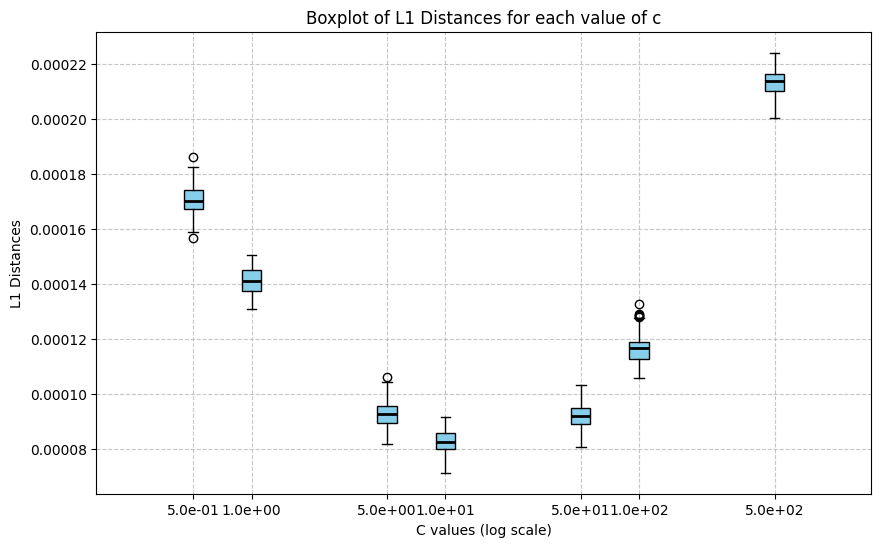

In [38]:
plt.figure(figsize=(10, 6))
box = plt.boxplot(
    L1_distances,
    # Hellinger_distances,                                            # Cambiare qui e il blocco sotto per plottare Hellinger (commentando il blocco con le distanze L1)
    positions=np.log10(c_values),
    widths=0.1,
    patch_artist=True
)

uniform_color = 'skyblue'
for patch in box['boxes']:
    patch.set_facecolor(uniform_color)
    patch.set_edgecolor('black')

for median in box['medians']:
    median.set_color('black')
    median.set_linewidth(2)


plt.xscale('linear')
plt.xticks(np.log10(c_values), labels=[f"{c:.1e}" for c in c_values])
plt.xlabel('C values (log scale)')

plt.ylabel('L1 Distances')
plt.title('Boxplot of L1 Distances for each value of c')

# plt.ylabel('Hellinger Distances')
# plt.title('Boxplot of Hellinger Distances for each value of c')

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()
